In [6]:
from pycodex import metadata, io, align
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import os
import pickle as pkl

import importlib
importlib.reload(align)

<module 'pycodex.align' from '/opt/miniconda3/envs/cellSeg/lib/python3.9/site-packages/pycodex/align.py'>

# 01. Data Overview

In [7]:
# Summary for markers of destination images
dst_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01"

dst_metadata_dict = io.organize_metadata_fusion(dst_dir, subfolders=False)
dst_unique_markers, _, _, _ = metadata.summary_markers(dst_metadata_dict)


Summary of Markers:
- Total unique markers: 20
- Unique markers: 20 ['BCL-xL', 'BCL6', 'CD11b', 'CD11c', 'CD169', 'CD19', 'CD31', 'CD4', 'CD45', 'CD79B', 'CD8', 'DAPI', 'HPV-E6', 'HPV-E7', 'TCRg_d', 'mTOR', 'p4EBP1', 'pCastor1', 'pS6', 'pSTAT3']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []


In [8]:
# Summary for markers of source images
src_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02"

src_metadata_dict = io.organize_metadata_fusion(src_dir, subfolders=False)
src_unique_markers, _, _, _ = metadata.summary_markers(src_metadata_dict)


Summary of Markers:
- Total unique markers: 18
- Unique markers: 18 ['CD127', 'CD163', 'CD20-B220', 'CD3', 'CD335', 'CD68', 'DAPI', 'F4-80', 'FOXO1', 'Foxp3', 'GranzymeB', 'H2Kb', 'Hexokinase1', 'Ki67', 'Ly6C', 'TCF1_7', 'cCaspase3', 'pAKT']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []


In [9]:
# Common markers in both destination and soruce images
[marker for marker in dst_unique_markers if marker in src_unique_markers]

['DAPI']

In [10]:
# Common marker for SIFT alignment
im_dst = tifffile.imread(os.path.join(dst_dir, "DAPI.tiff"))
im_src = tifffile.imread(os.path.join(src_dir, "DAPI.tiff"))

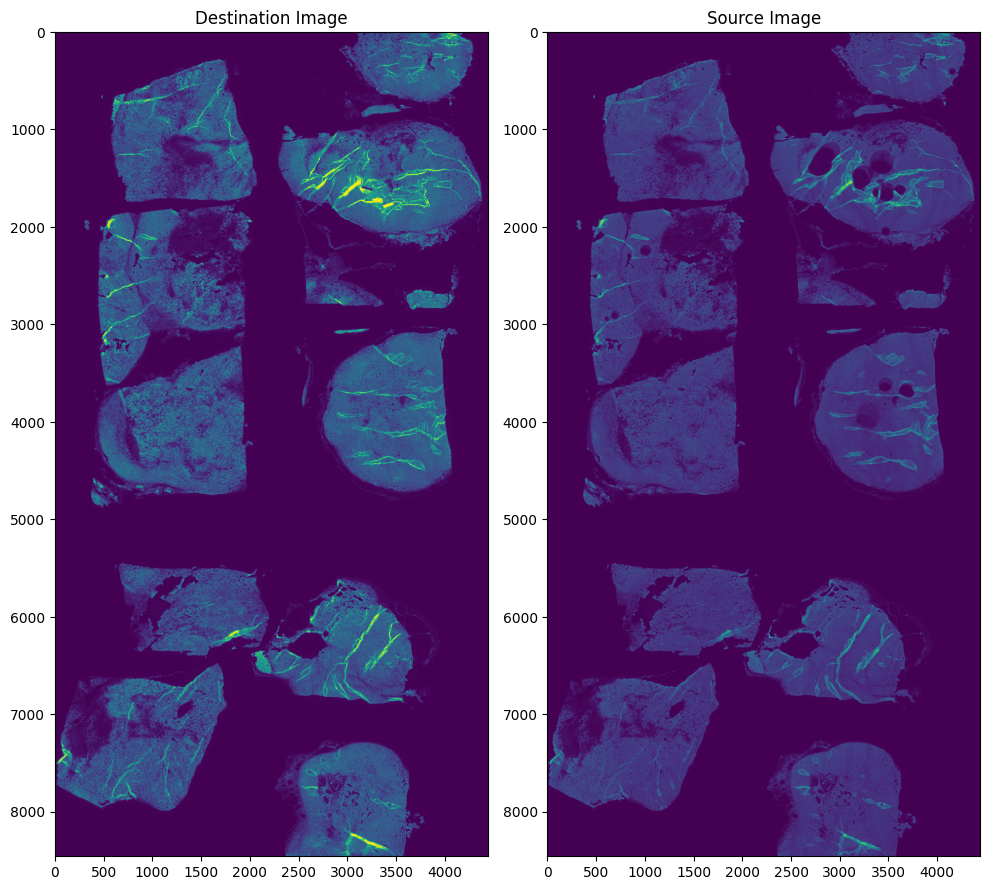

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs = axs.flatten()

axs[0].imshow(im_dst[::8, ::8])
axs[0].set_title("Destination Image")

axs[1].imshow(im_src[::8, ::8])
axs[1].set_title("Source Image")

plt.tight_layout()
plt.show()


# 02. SIFT Alignment

In [12]:
sift_matcher = align.SIFTMatcher(im_src, im_dst, step=8)


Initialize SIFT detector
Find keypoints and descriptors
Initialize matcher
Match descriptors


In [13]:
sift_matcher.find_kp_intersections()


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


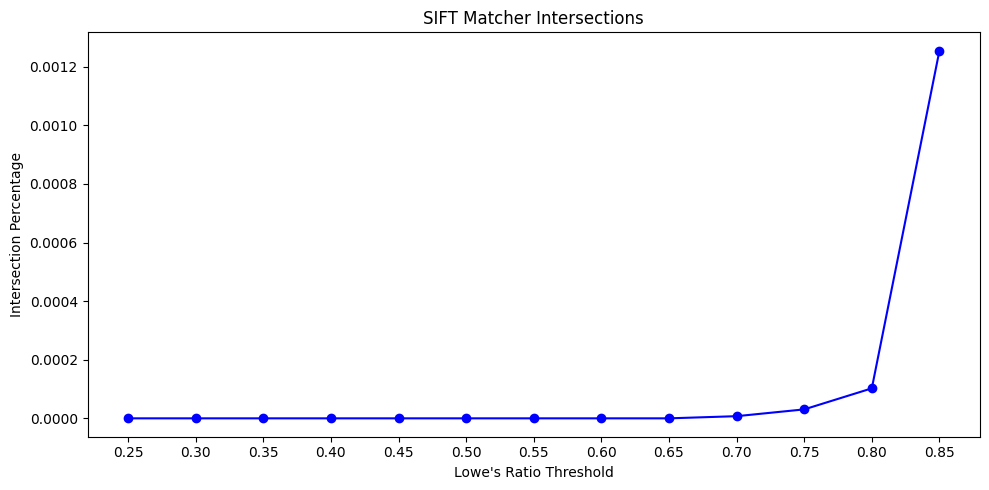

In [14]:
sift_matcher.plot_kp_intersections()


Apply Lowe's ratio threshold


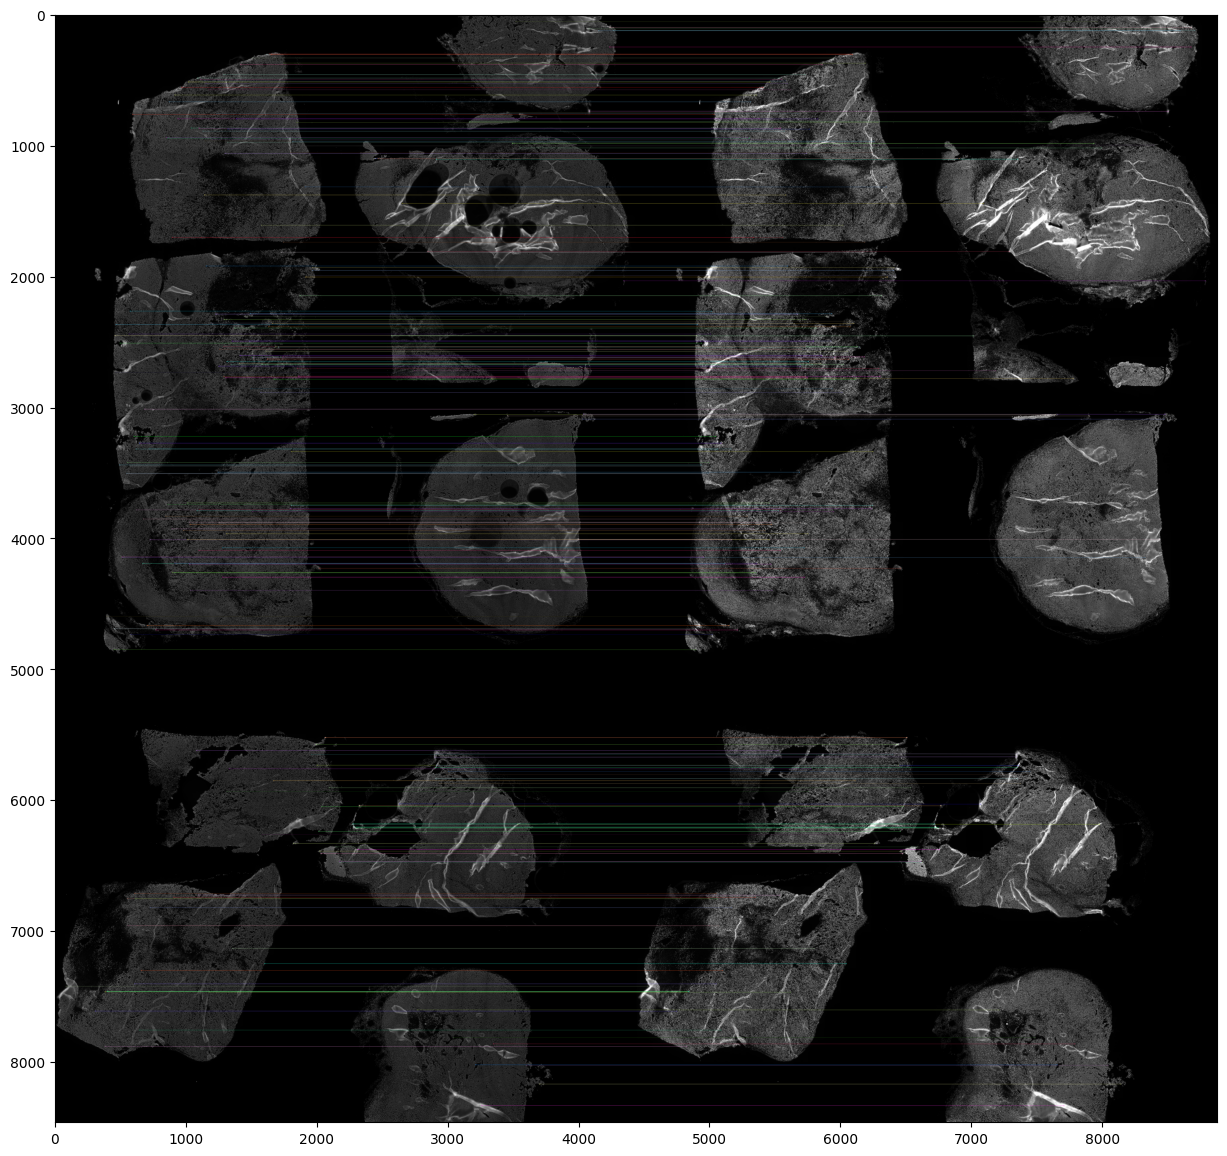

In [15]:
# set appropriate Lowe's ratio threshold
sift_matcher.set_lowe_ratio_threshold(0.5)

In [16]:
H, H_inverse = sift_matcher.compute_affine_matrix()
im_src_trans, blank_mask = align.apply_affine_transformation(im_src, im_dst.shape, H_inverse)

Extract matched keypoints
Compute affine transformation


In [17]:
# percentage of non-overlap region
f"masked percentage (%): {np.mean(blank_mask) * 100}"

'masked percentage (%): 0.018159823719996592'

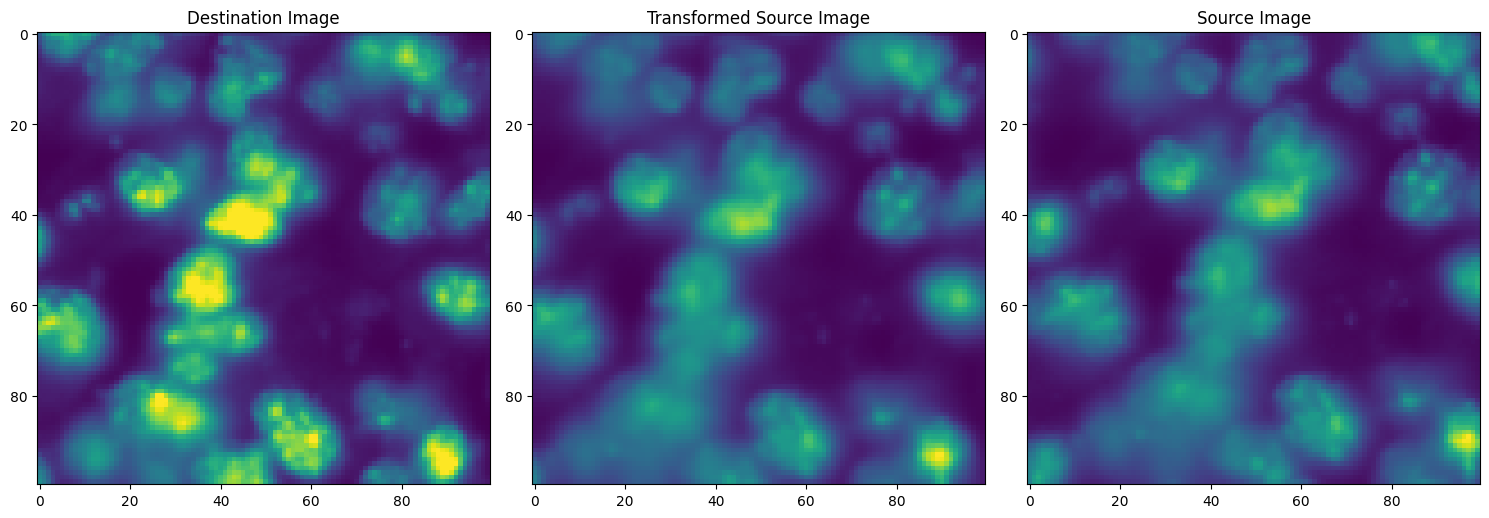

In [22]:
# alignment performance
x_beg = 8000
y_beg = 8000
length = 100

im_dst_sm = im_dst[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_trans_sm = im_src_trans[y_beg : (y_beg + length), x_beg : (x_beg + length)]
im_src_sm = im_src[y_beg : (y_beg + length), x_beg : (x_beg + length)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axs = axs.flatten()

axs[0].imshow(im_dst_sm)
axs[0].set_title("Destination Image")

axs[1].imshow(im_src_trans_sm)
axs[1].set_title("Transformed Source Image")

axs[2].imshow(im_src_sm)
axs[2].set_title("Source Image")

plt.tight_layout()
plt.show()


# 03. Parameter Output

In [19]:
output_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi"

os.makedirs(output_dir, exist_ok=True)
data = {"H_inverse": H_inverse, "blank_mask": blank_mask, "output_shape": im_dst.shape}

output_path = os.path.join(output_dir, "sift_parameter.pkl")
if os.path.exists(output_path):
    print(f"File already exists: {output_path}.")
else:
    with open(output_path, "wb") as f:
        pkl.dump(data, f)


# 04. SIFT Alignment for All Markers

In [24]:
print(f"dst_dir = '{dst_dir}'\n" f"src_dir = '{src_dir}'\n" f"output_dir = '{output_dir}'\n")

dst_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01'
src_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02'
output_dir = '/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi'



In [21]:
# images as reference
dst_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw01"
# images to be aligned to reference
src_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/data/Male_WT+KO_36dpi/raw02"
output_dir = "/mnt/nfs/home/wenruiwu/projects/precious_alignment/output/Male_WT+KO_36dpi"

# test image folders
dst_metadata_dict = io.organize_metadata_fusion(dst_dir, subfolders=False)
dst_unique_markers, _, _, _ = metadata.summary_markers(dst_metadata_dict)
src_metadata_dict = io.organize_metadata_fusion(src_dir, subfolders=False)
src_unique_markers, _, _, _ = metadata.summary_markers(src_metadata_dict)

Summary of Markers:
- Total unique markers: 20
- Unique markers: 20 ['BCL-xL', 'BCL6', 'CD11b', 'CD11c', 'CD169', 'CD19', 'CD31', 'CD4', 'CD45', 'CD79B', 'CD8', 'DAPI', 'HPV-E6', 'HPV-E7', 'TCRg_d', 'mTOR', 'p4EBP1', 'pCastor1', 'pS6', 'pSTAT3']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []
Summary of Markers:
- Total unique markers: 18
- Unique markers: 18 ['CD127', 'CD163', 'CD20-B220', 'CD3', 'CD335', 'CD68', 'DAPI', 'F4-80', 'FOXO1', 'Foxp3', 'GranzymeB', 'H2Kb', 'Hexokinase1', 'Ki67', 'Ly6C', 'TCF1_7', 'cCaspase3', 'pAKT']
- Blank markers: 0 []
- Markers duplicated in some regions: 0 []
- Markers missing in some regions: 0 []
